In [109]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint

import numpy as np
import pylab as pl
from importlib import reload  

from src import *

In [110]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 4    # Number of pixels used to pad the target image border
TARGET_SIZE = 20       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 16
CELL_FIRE_RATE = 0.5

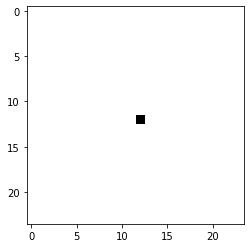

In [111]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0])

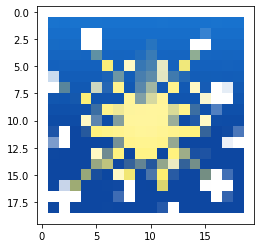

In [5]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [6]:
# Define the model
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

target = target.to(device)
model = CustomCA(16, 16, device)

In [8]:
# Train the model
torch.backends.cudnn.benchmark = True # Speeds up training
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
criterion = CustomLoss(pad(target, TARGET_PADDING), torch.nn.MSELoss, 16)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, batch_size=16, n_epochs=300, scheduler=scheduler, kind="growing")

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


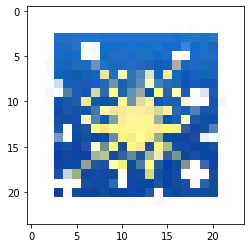

In [29]:
imshow(model.evolve(pool.sample(1)[0].cuda(), 500)[0])

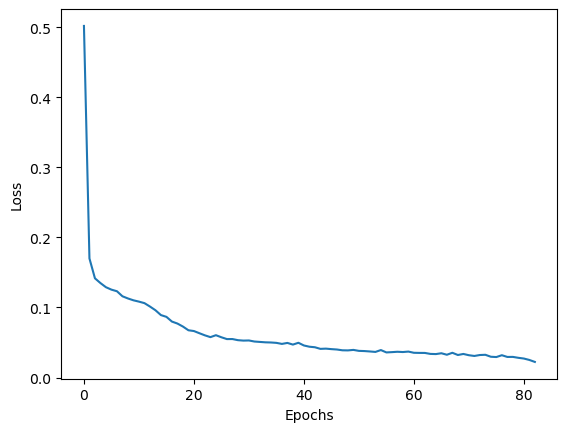

In [14]:
pl.plot(model.losses)
pl.xlabel("Epochs")
pl.ylabel("Loss")
pl.show()

In [8]:
# Make evolution video
model.make_video(video_size=IMAGE_SIZE, n_iters=N_ITERS*2, fps=10, rescaling=8)

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1301.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


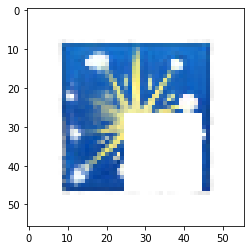

In [57]:
# A damaged image
imshow(pool[3][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(tensor(0.0006, device='cuda:0'), tensor(0, device='cuda:0'))


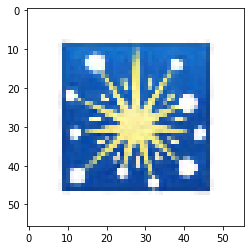

In [68]:
# After N_ITERS*5 the CA perfectly corrects it
x, _ = pool[3:4]
x = x.to(device)
x = model.evolve(x, N_ITERS*5)
print(criterion(x))
imshow(x[0])